In [1]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import cufflinks as cf
import tensorflow
from tensorflow.keras import Sequential
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_excel('/content/drive/MyDrive/Ecommerce Sentiment Analysis/Dataset/Bangla.xlsx')

In [5]:
newdf = df.copy()

In [6]:
df.head()

,Comments,sentiment
0,এই পণ্য ভাল না।,Negative
1,১০০% অথেন্টিক প্রডাক্ট,Positive
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive
3,পিকাবো থেকে চমৎকার সেবা।,Positive
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive


In [7]:
df["sentiment"].unique()

array(['Negative', 'Positive'], dtype=object)

In [8]:
df.shape

(2577, 2)

In [9]:
print("Total Comment:",len(df),
      "\nTotal Negative :",len(df[df.sentiment =='Negative']),
      "\nTotal Positive :",len(df[df.sentiment=='Positive']))

Total Comment: 2577 
Total Negative : 1138 
Total Positive : 1439


In [10]:
import os

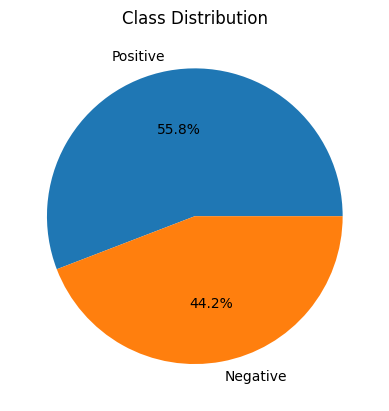

In [11]:
class_counts = df['sentiment'].value_counts()
class_percents = class_counts / class_counts.sum() * 100
# Plot the pie chart
plt.pie(class_percents, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.savefig("my_plot.png")
plt.show()

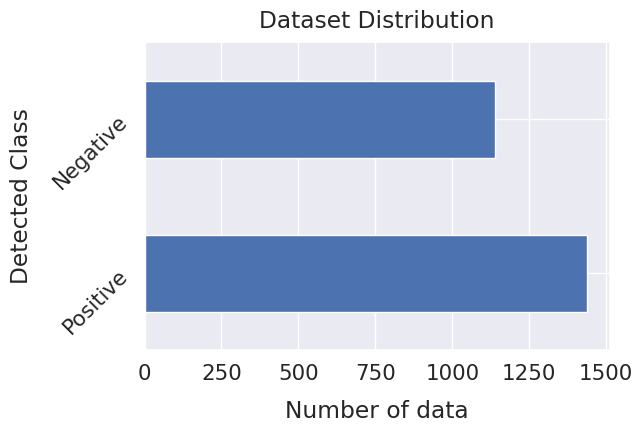

In [12]:
sns.set(font_scale=1.4)
df['sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of data", labelpad=12)
plt.ylabel("Detected Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);
plt.savefig("Dataset Distribution BarChart.png")

# **Data Preperation and Cleaning**

# **Removing Duplicate Rows**

In [13]:
# df.drop_duplicates(inplace=True)

# **Stopwords Removal**

In [14]:
def process_conversations(Conversation):
    stp = open('/content/drive/MyDrive/Ecommerce Sentiment Analysis/Code Porter/stopwords-bn (1).txt','r',encoding="utf8").read().split()
    result = Conversation.split()
    Conversation = [word.strip() for word in result if word not in stp ]
    Conversation =" ".join(Conversation)
    Conversation = re.sub('[^\u0980-\u09FF]',' ',str(Conversation))
    return Conversation

In [15]:
df.dtypes

Comments     object
sentiment    object
dtype: object

In [16]:
df['cleaned'] = df['Comments'].apply(process_conversations)
sample_data = [10,700]
for i in sample_data:
     print('Original:\n',df.Comments[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Detected as:-- ',df.sentiment[i],'\n')

Original:
 আপনি এটা অনুশোচনা করবে না। 
Cleaned:
 অনুশোচনা না  
 Detected as:--  Positive 

Original:
 এই দ্রেসের ফ্যাব্রিক অসাধারণ এবং এটি নিখুত ফিট করে। 
Cleaned:
 দ্রেসের ফ্যাব্রিক অসাধারণ নিখুত ফিট করে  
 Detected as:--  Negative 



In [17]:
df

,Comments,sentiment,cleaned
0,এই পণ্য ভাল না।,Negative,পণ্য ভাল না
1,১০০% অথেন্টিক প্রডাক্ট,Positive,১০০ অথেন্টিক প্রডাক্ট
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive,৩ বছরের ওয়ারেন্টিও আছে
3,পিকাবো থেকে চমৎকার সেবা।,Positive,পিকাবো চমৎকার সেবা
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive,পিওরিট সম্পর্কে সন্দেহ নেই
...,...,...,...
2572,"হেডফোনটা সত্যিই অসাধারণ , অনেক সুন্দর সাউন্ড এ...",Positive,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে স...
2573,হেডফোনের গুণমান এই মূল্য পরিসরে ভাল নয়।,Negative,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়
2574,"হেভি গেমিং এর জন্য বেস্ট, ক্যামেরাও অনেক ভালো",Positive,হেভি গেমিং বেস্ট ক্যামেরাও ভালো
2575,হ্যাঁ খুশি ভাল অবস্থা,Positive,হ্যাঁ খুশি ভাল অবস্থা


# **Removing Small Texts**

In [18]:
df['length'] = df['cleaned'].apply(lambda x:len(x.split()))

dataset = df.loc[df.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small conversations".format(len(df)-len(dataset)),
      "\nTotal conversations:",len(dataset))

dataset['no_char'] = df['cleaned'].apply(lambda cleaned: len(cleaned))

After Cleaning: 
Removed 0 Small conversations 
Total conversations: 2577


In [19]:
mydataset=dataset

In [20]:
dataset

,Comments,sentiment,cleaned,length,no_char
0,এই পণ্য ভাল না।,Negative,পণ্য ভাল না,3,12
1,১০০% অথেন্টিক প্রডাক্ট,Positive,১০০ অথেন্টিক প্রডাক্ট,3,22
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive,৩ বছরের ওয়ারেন্টিও আছে,4,23
3,পিকাবো থেকে চমৎকার সেবা।,Positive,পিকাবো চমৎকার সেবা,3,19
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive,পিওরিট সম্পর্কে সন্দেহ নেই,4,27
...,...,...,...,...,...
2572,"হেডফোনটা সত্যিই অসাধারণ , অনেক সুন্দর সাউন্ড এ...",Positive,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে স...,13,88
2573,হেডফোনের গুণমান এই মূল্য পরিসরে ভাল নয়।,Negative,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়,6,37
2574,"হেভি গেমিং এর জন্য বেস্ট, ক্যামেরাও অনেক ভালো",Positive,হেভি গেমিং বেস্ট ক্যামেরাও ভালো,5,32
2575,হ্যাঁ খুশি ভাল অবস্থা,Positive,হ্যাঁ খুশি ভাল অবস্থা,4,21


# **Stemming**

In [21]:
# !pip install bangla-stemmer
# from bangla_stemmer.stemmer import stemmer
# ## stemmer function
# def stem_text (x):
#   stmr = stemmer.BanglaStemmer()
#   words=x.split(' ')
#   stm = stmr.stem(words)
#   words=(' ').join(stm)
#   return words

In [22]:
from nltk.stem import LancasterStemmer, PorterStemmer
import pandas as pd

# Instantiate stemmers
lancaster_stemmer = LancasterStemmer()
# Define stemming functions
def lancaster_stemming(text):
    return ' '.join([lancaster_stemmer.stem(word) for word in text.split()])

dataset['LancasterStemming'] = dataset['cleaned'].apply(lancaster_stemming)

In [23]:
dataset.head()

,Comments,sentiment,cleaned,length,no_char,LancasterStemming
0,এই পণ্য ভাল না।,Negative,পণ্য ভাল না,3,12,পণ্য ভাল না
1,১০০% অথেন্টিক প্রডাক্ট,Positive,১০০ অথেন্টিক প্রডাক্ট,3,22,১০০ অথেন্টিক প্রডাক্ট
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive,৩ বছরের ওয়ারেন্টিও আছে,4,23,৩ বছরের ওয়ারেন্টিও আছে
3,পিকাবো থেকে চমৎকার সেবা।,Positive,পিকাবো চমৎকার সেবা,3,19,পিকাবো চমৎকার সেবা
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive,পিওরিট সম্পর্কে সন্দেহ নেই,4,27,পিওরিট সম্পর্কে সন্দেহ নেই


In [24]:
# dataset['stemming']=dataset['cleaned'].apply(stem_text)

In [25]:
dataset

,Comments,sentiment,cleaned,length,no_char,LancasterStemming
0,এই পণ্য ভাল না।,Negative,পণ্য ভাল না,3,12,পণ্য ভাল না
1,১০০% অথেন্টিক প্রডাক্ট,Positive,১০০ অথেন্টিক প্রডাক্ট,3,22,১০০ অথেন্টিক প্রডাক্ট
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive,৩ বছরের ওয়ারেন্টিও আছে,4,23,৩ বছরের ওয়ারেন্টিও আছে
3,পিকাবো থেকে চমৎকার সেবা।,Positive,পিকাবো চমৎকার সেবা,3,19,পিকাবো চমৎকার সেবা
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive,পিওরিট সম্পর্কে সন্দেহ নেই,4,27,পিওরিট সম্পর্কে সন্দেহ নেই
...,...,...,...,...,...,...
2572,"হেডফোনটা সত্যিই অসাধারণ , অনেক সুন্দর সাউন্ড এ...",Positive,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে স...,13,88,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে সাউ...
2573,হেডফোনের গুণমান এই মূল্য পরিসরে ভাল নয়।,Negative,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়,6,37,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়
2574,"হেভি গেমিং এর জন্য বেস্ট, ক্যামেরাও অনেক ভালো",Positive,হেভি গেমিং বেস্ট ক্যামেরাও ভালো,5,32,হেভি গেমিং বেস্ট ক্যামেরাও ভালো
2575,হ্যাঁ খুশি ভাল অবস্থা,Positive,হ্যাঁ খুশি ভাল অবস্থা,4,21,হ্যাঁ খুশি ভাল অবস্থা


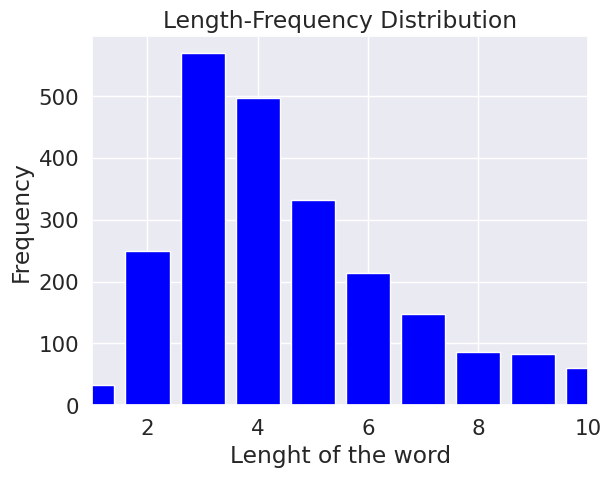

Maximum Length of a comment: 65
Minimum Length of a comment: 1
Average Length of a comment: 6.0


<Figure size 640x480 with 0 Axes>

In [26]:
frequency = dict()
for i in dataset.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 10)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.length)}")
print(f"Minimum Length of a comment: {min(dataset.length)}")
print(f"Average Length of a comment: {round(np.mean(dataset.length),0)}")

plt.savefig("Length-Frequency Distribution Bangla BarChart.png")

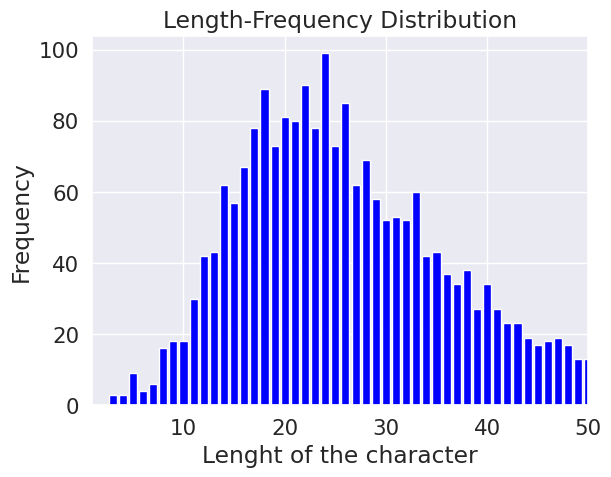

Maximum Length of a comment: 443
Minimum Length of a comment: 3
Average Length of a comment: 38.0


<Figure size 640x480 with 0 Axes>

In [27]:
frequency = dict()
for i in dataset.no_char:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 50)

plt.xlabel('Lenght of the character')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.no_char)}")
print(f"Minimum Length of a comment: {min(dataset.no_char)}")
print(f"Average Length of a comment: {round(np.mean(dataset.no_char),0)}")
plt.savefig("Character Frequency Distribution Bangla BarChart.png")

# **Data Set Summary**

In [28]:
def data_summary(dataset):
    documents = []
    words = []
    most_frequent_word =[]
    u_words = []

    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.sentiment.value_counts().to_dict().items()]

    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.sentiment==label].cleaned) for word in t.strip().split()]

        counts = dict()

        for word in word_list:
                counts[word] = counts.get(word, 0)+1

        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)

        documents.append(len(list(dataset[dataset.sentiment==label].cleaned)))

        words.append(len(word_list))

        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of comments:{}".format(len(list(dataset[dataset.sentiment==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:15]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Positive
Number of comments:1439
Number of Words:8566
Number of Unique Words:2142
Most Frequent Words:

ভালো	400
ভাল	257
ধন্যবাদ	187
সুন্দর	145
দাম	125
প্রোডাক্ট	115
পণ্য	110
পেয়েছি	88
খুবই	77
আলহামদুলিল্লাহ	77
দামে	76
মানের	76
টা	73
সেলার	72
কম	71

Class Name :  Negative
Number of comments:1138
Number of Words:6632
Number of Unique Words:2189
Most Frequent Words:

না	152
ভালো	115
বাজে	93
খারাপ	86
প্রোডাক্ট	84
একটা	80
কোয়ালিটি	68
পণ্য	62
ভাল	62
মানের	56
সাথে	55
দারাজ	55
খুবই	54
টা	53
অর্ডার	52
Total Number of Unique Words:3529


***New Dataframe for Data Summary***

In [29]:
data_matrix = pd.DataFrame({'Total comments':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")

In [30]:
data

,Class Names,Category,Values
0,Positive,Total comments,1439
1,Negative,Total comments,1138
2,Positive,Total Words,8566
3,Negative,Total Words,6632
4,Positive,Unique Words,2142
5,Negative,Unique Words,2189


***Data Summary Visualization***

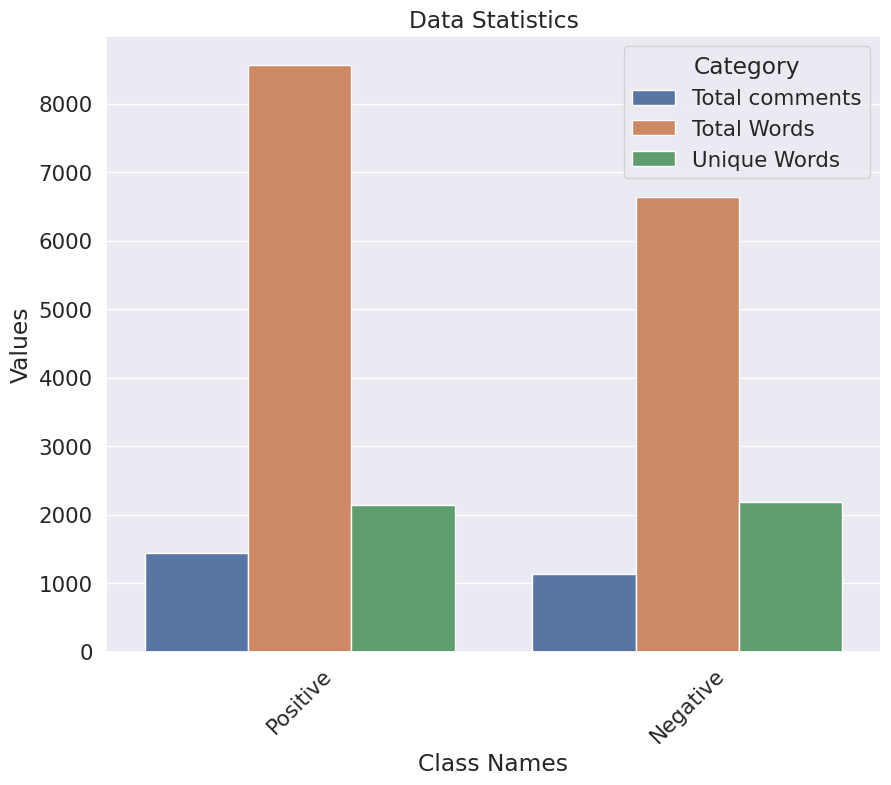

In [31]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.barplot(data=data,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

plt.savefig("Data Statistics Bangla BarChart.png")

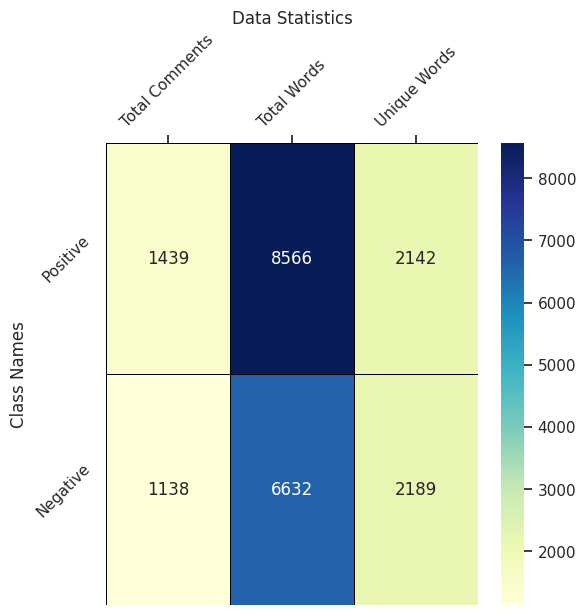

In [32]:
sns.set()
plt.figure(figsize =(6, 6))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)

ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Comments", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()
plt.savefig("Data Statistics Bangla.png")

In [33]:
dataset.cleaned = dataset.LancasterStemming.apply(lambda x:x.replace('\n',' '))

In [34]:
dataset

,Comments,sentiment,cleaned,length,no_char,LancasterStemming
0,এই পণ্য ভাল না।,Negative,পণ্য ভাল না,3,12,পণ্য ভাল না
1,১০০% অথেন্টিক প্রডাক্ট,Positive,১০০ অথেন্টিক প্রডাক্ট,3,22,১০০ অথেন্টিক প্রডাক্ট
2,৩ বছরের ওয়ারেন্টিও আছে!,Positive,৩ বছরের ওয়ারেন্টিও আছে,4,23,৩ বছরের ওয়ারেন্টিও আছে
3,পিকাবো থেকে চমৎকার সেবা।,Positive,পিকাবো চমৎকার সেবা,3,19,পিকাবো চমৎকার সেবা
4,পিওরিট সম্পর্কে কোন সন্দেহ নেই।,Positive,পিওরিট সম্পর্কে সন্দেহ নেই,4,27,পিওরিট সম্পর্কে সন্দেহ নেই
...,...,...,...,...,...,...
2572,"হেডফোনটা সত্যিই অসাধারণ , অনেক সুন্দর সাউন্ড এ...",Positive,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে সাউ...,13,88,হেডফোনটা সত্যিই অসাধারণ সুন্দর সাউন্ড জোরে সাউ...
2573,হেডফোনের গুণমান এই মূল্য পরিসরে ভাল নয়।,Negative,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়,6,37,হেডফোনের গুণমান মূল্য পরিসরে ভাল নয়
2574,"হেভি গেমিং এর জন্য বেস্ট, ক্যামেরাও অনেক ভালো",Positive,হেভি গেমিং বেস্ট ক্যামেরাও ভালো,5,32,হেভি গেমিং বেস্ট ক্যামেরাও ভালো
2575,হ্যাঁ খুশি ভাল অবস্থা,Positive,হ্যাঁ খুশি ভাল অবস্থা,4,21,হ্যাঁ খুশি ভাল অবস্থা


In [35]:
dataset=dataset.drop(["Comments","cleaned","length","no_char"],axis=1)

In [36]:
dataset.columns=["sentiment","cleaned"]

In [37]:
dataset.head()

,sentiment,cleaned
0,Negative,পণ্য ভাল না
1,Positive,১০০ অথেন্টিক প্রডাক্ট
2,Positive,৩ বছরের ওয়ারেন্টিও আছে
3,Positive,পিকাবো চমৎকার সেবা
4,Positive,পিওরিট সম্পর্কে সন্দেহ নেই


# ***Unigram Tf-idf value calculation***

In [38]:
def calc_gram_tfidf(Conversations):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(Conversations)

    return tfidf,X

# **Unigram**

In [39]:
x = ["আমি মনে করি আমি আমার টাকা অপচয়"]

def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

get_top_n_words(x,3)

[('আম', 3), ('মন', 1), ('কর', 1)]

# **Bigram**

In [40]:
y = ["আমি মনে করি আমি আমার টাকা অপচয়"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(y,3)

[('আম মন', 1), ('মন কর', 1), ('কর আম', 1)]

# **Tigram**

In [41]:
z = ["আমি মনে করি আমি আমার টাকা অপচয়"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(z,3)

[('আম মন কর', 1), ('মন কর আম', 1), ('কর আম আম', 1)]

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
# gram_names = ['Unigram','Bigram','Trigram']
# ngrams = [(1,1),(1,2),(1,3)]

# for i,gram in enumerate(ngrams):
#      tfidf,feature = calc_gram_tfidf(dataset.stemming)
#      labels = label_encoding(dataset.sentiment,False)
#      X_train,X_test,y_train,y_test = dataset_split(feature,labels)
#      ml_models,model_names = ml_models_defination()
#      accuracy = {f'{model_names[j]}': model_performance(model, X_train, X_test, y_train, y_test) for j, model in enumerate(ml_models)}

#      with open(f'ml_performance_{gram_names[i]}.json', 'w') as f:
#            json.dump(accuracy,f)

# **Tokenization**

In [44]:
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['cleaned'].values)
X = tokenizer.texts_to_sequences(dataset['cleaned'].values)
X = pad_sequences(X)

In [45]:
X

array([[  0,   0,   0, ...,   6,   2,   5],
       [  0,   0,   0, ..., 172, 327,  27],
       [  0,   0,   0, ...,   0, 249,  46],
       ...,
       [  0,   0,   0, ...,   0, 217,   1],
       [  0,   0,   0, ...,  77,   2, 333],
       [  0,   0,   0, ...,   0,  16, 333]], dtype=int32)

In [46]:
np.shape(X)

(2577, 43)

# **Model Creation**

# **CNN**

In [47]:
X.shape

(2577, 43)

In [48]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

embed_dim = 64
model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length=X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 64)            32000     
                                                                 
 conv1d (Conv1D)             (None, 39, 128)           41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 106,626
Trainable params: 106,626
Non-trainable params: 0
__________________________________________________

In [49]:
Y = pd.get_dummies(dataset['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2061, 43) (2061, 2)
(516, 43) (516, 2)


In [50]:
history=model.fit(X_train, Y_train, epochs = 50, batch_size=32, verbose = 1,validation_data=(X_test,Y_test))

Epoch 1/50
65/65 [==============================] - 4s 26ms/step - loss: 0.6907 - accuracy: 0.5522 - val_loss: 0.6861 - val_accuracy: 0.5601
Epoch 2/50
65/65 [==============================] - 1s 15ms/step - loss: 0.6674 - accuracy: 0.5633 - val_loss: 0.6402 - val_accuracy: 0.7965
Epoch 3/50
65/65 [==============================] - 1s 16ms/step - loss: 0.6088 - accuracy: 0.8239 - val_loss: 0.5964 - val_accuracy: 0.8004
Epoch 4/50
65/65 [==============================] - 1s 16ms/step - loss: 0.5617 - accuracy: 0.8515 - val_loss: 0.5607 - val_accuracy: 0.8159
Epoch 5/50
65/65 [==============================] - 1s 16ms/step - loss: 0.5253 - accuracy: 0.8709 - val_loss: 0.5382 - val_accuracy: 0.8314
Epoch 6/50
65/65 [==============================] - 1s 16ms/step - loss: 0.5034 - accuracy: 0.8734 - val_loss: 0.5245 - val_accuracy: 0.8275
Epoch 7/50
65/65 [==============================] - 1s 16ms/step - loss: 0.4777 - accuracy: 0.8884 - val_loss: 0.5094 - val_accuracy: 0.8314
Epoch 8/50
65

In [51]:
import tensorflow as tf

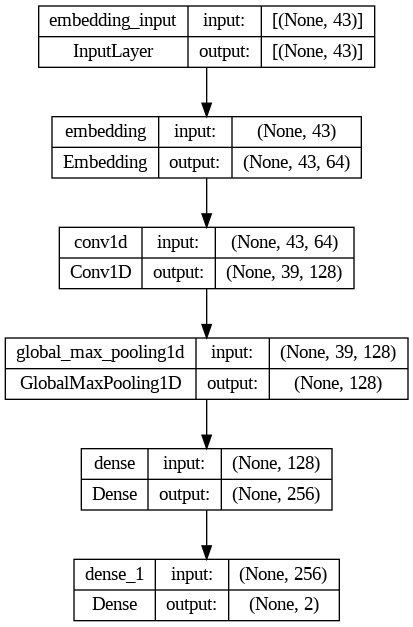

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-0mu0le6i
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-0mu0le6i
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.7 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13719 sha256=17628eace3e751367dd0da44717ab7bbde69d20fcffa44cf9d7f2bc6e6f42759
  Stored in directory: /tmp/pip-ephem-wheel-cache-79apfpay/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


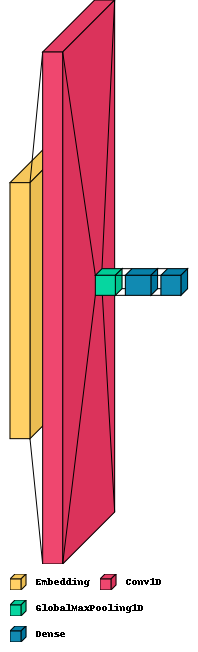

In [53]:
from tensorflow.keras.models import Model
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

# **Evaluation**

In [54]:
score = model.evaluate(X_train, Y_train,batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

33/33 - 0s - loss: 0.2355 - accuracy: 0.9287 - 271ms/epoch - 8ms/step
Train loss: 0.23546206951141357
Train accuracy: 0.9286754131317139


In [55]:
score = model.evaluate(X_test, Y_test,batch_size=64, verbose=2)
print('Test loss:', score[0])
acc=score[1]
print('Test accuracy:', acc)


9/9 - 0s - loss: 0.4761 - accuracy: 0.8217 - 119ms/epoch - 13ms/step
Test loss: 0.4761117994785309
Test accuracy: 0.8217054009437561


# **Learning Curve**

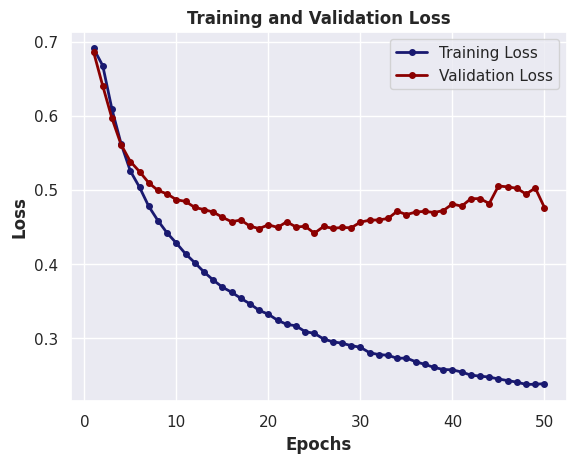

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, loss_values, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Loss')
plt.plot(epochs, val_loss_values, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

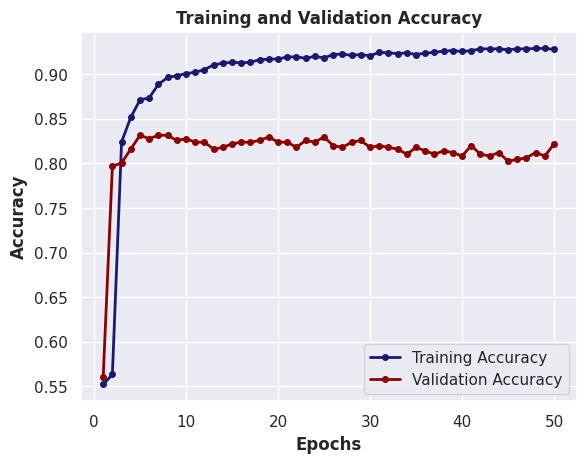

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, acc, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


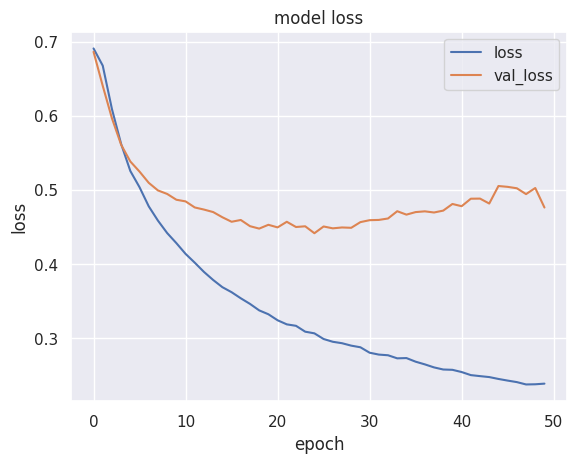

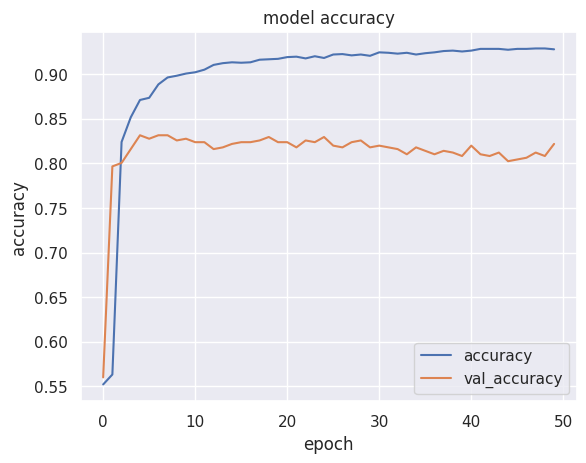

In [58]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### **Confusion Matrix & Classification Report**

In [59]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((2061, 43), (2061, 2), (516, 43), (516, 2))

In [60]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

17/17 [==============================] - 0s 9ms/step
[[187  40]
 [ 52 237]]


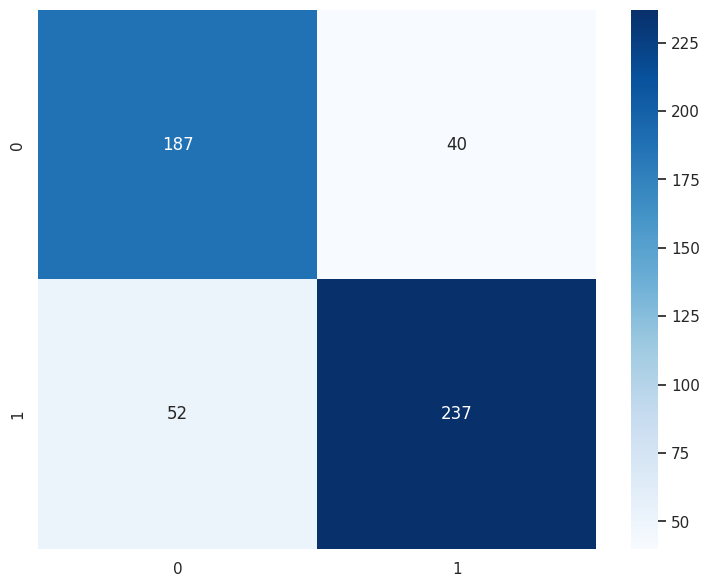

In [61]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm,cmap='Blues', annot=True,fmt='d')
plt.show()


In [62]:
# print(classification_report(y_test, y_pred))

In [63]:
from sklearn.metrics import classification_report

In [64]:
report = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose()

In [65]:
report = report.rename(index={'0': 'Positive','1':'Negative'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))

In [66]:
report

,precision,recall,f1-score,support
Positive,78.24,82.38,80.26,227.000000
Negative,85.56,82.01,83.75,289.000000
accuracy,82.17,82.17,82.17,0.821705
macro avg,81.90,82.19,82.00,516.000000
weighted avg,82.34,82.17,82.21,516.000000


In [67]:
twt = ['২৪২ টাকায় মোটামুটি ভালো, ১০ এ ৮ দেওয়া যায়। দারাজ এবং সেলার কে অনেক অনেক ধন্যবাদ। যা ORDER করছি তা পেয়েছি, তার জন্য ধন্যবাদ। আর ছবিতে যা দেখছি যে কোয়ালিটি দেখছি তা পাইছি']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("Positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0 138  83   1 105  13  19
  126  91  18 100 441  76 350  14 350  82]]
1/1 - 0s - 111ms/epoch - 111ms/step
Positive


In [68]:
X_train, X_test, y_train, y_test = train_test_split(mydataset['Comments'], dataset['sentiment'], test_size=0.2, random_state=42)

In [69]:
X_test.shape

(516,)

In [70]:
y_test.shape,y_pred.shape

((516,), (516,))

In [71]:
import pandas as pd
import numpy as np

# Create an empty dataframe
df = pd.DataFrame()

# Set the comments in the dataframe
df['Comments'] = X_test

# Add the actual sentiment and predicted sentiment columns if available
df['Actual Sentiment'] = y_test

# Print unique values in y_pred
unique_values = np.unique(y_pred)
print("Unique Values in y_pred:", unique_values)

# Replace values in the Predicted Sentiment column
df['Predicted Sentiment'] = np.where(y_pred == unique_values[0], 'Negative', 'Positive')
# Reshape y_pred to have two dimensions
predicted_percentage = y_pred * 100

# Add the predicted percentage column
df['Predicted Percentage'] = predicted_percentage

Unique Values in y_pred: [0 1]


In [72]:
# accuracy

In [73]:
df.tail(30)

,Comments,Actual Sentiment,Predicted Sentiment,Predicted Percentage
949,এটা মোটেও ফিটিং না।প্রচন্ড ডোলা,Negative,Negative,0
438,আমি এক মাসেই ভাল ফল পেয়েছি।,Positive,Negative,0
480,আমি প্রথমে মনে করেছিলাম এই প্রোডাক্টটি কাপড়ের...,Positive,Negative,0
457,আমি কম দামে একটি ভাল পণ্য পেয়েছিলাম।,Positive,Positive,100
163,৬ মাস ধরে ব্যবহার করছি এখনো ঠিক সার্ভিস দিচ্ছে।,Positive,Positive,100
402,আমি অনেক খুশি হয়েছি এই প্রোডাক্ট পেয়ে।যেমন চেয়...,Positive,Positive,100
2059,বিক্রেতার বিশ্বাসযোগ্যতা বিচার করে আমি লেজার প...,Positive,Positive,100
620,আসল পণ্য পয়েছি।,Positive,Negative,0
1467,টিশার্ট টা মোটামুটি ভালো🙂 কিন্তু পেন্টটা একদম ...,Negative,Negative,0
166,৭ দিনের মধ্যে নষ্ট হয়ে গেছে।,Negative,Negative,0
